<a href="https://colab.research.google.com/github/JungAh12/Everyone_TF2.0/blob/master/TextClassificationwithPreprocessedText.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#영화 리뷰를 사용한 텍스트 분류

In [1]:
!pip install -q tf-nightly-2.0-preview
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

     |████████████████████████████████| 95.2MB 66kB/s 
     |████████████████████████████████| 450kB 49.5MB/s 
     |████████████████████████████████| 3.8MB 43.0MB/s 
     |████████████████████████████████| 81kB 11.5MB/s 
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.
ERROR: tb-nightly 2.1.0a20191201 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
2.0.0-dev20191002


#IMDB 데이터셋 다운로드

num_words=10000은 train data에서 가장 많이 등장하는 상위 10000개의 단어를 선택한다.

In [2]:
imdb = keras.datasets.imdb

(train_data, train_labels),(test_data,test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 0s 0us/step


#데이터 형태 살펴보기

In [3]:
print("훈련 샘플 : {}, 레이블 : {}".format(len(train_data), len(train_labels)))

훈련 샘플 : 25000, 레이블 : 25000


In [4]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [5]:
len(train_data[0]), len(train_data[1])  # 각 리뷰의 단어 수

(218, 189)

#정수를 단어로 변환하기
정수와 문자열을 매핑한 딕셔너리 객체에 질의하는 헬퍼 함수를 만들자.

In [6]:
# 정수, 단어 매핑한 딕셔너리
word_index = imdb.get_word_index()

# 첫 몇 개 인덱스는 사전에 정의 되어 있다.
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key,value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1646592/1641221 [==============================] - 0s 0us/step


reverse_word_index는 key, value를 value, key형태로 딕셔너리를 새로 만들어주는 것이다.

그래야 쉽게 정수를 단어로 변환할 수 있기 때문이다.

In [7]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

#데이터 준비
신경망에 input data로 사용할 때 텐서 형태로 변환되어야 한다.

변환하는 방법은 다음과 같다.
- one-hot encoding : 정수 배열을 0과 1로 이루어진 벡터로 변환한다. 이 방법은 메모리가 많이 필요하다.

- 정수 배열 길이가 모두 같게 padding을 추가한다.

In [0]:
#keras에 pad_sequences함수를 사용해서 배열 길이를 맞춰 텐서로 만들 수 있다.

train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)
test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [9]:
#샘플 길이 확인
len(train_data[0]), len(test_data[0])

(256, 256)

In [10]:
#패딩된 데이터 확인
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

#모델 구성
Embedding layer : 정수로 인코딩된 단어를 입력 받고 각 단어 인덱스에 해당하는 임베딩 벡터를 찾는다. 이 벡터는 모델이 훈련되면서 학습된다. 측 최종 차원이 (batch, sequence, embedding)이 된다.

GlobalAveragePooling1D : sequence 차원에 대해 평균을 계산하여 각 샘플에 대해 고정된 길이의 출력 벡터를 반환한다. ** 길이가 다른 입력을 다루는 가장 간단한 방법 **

Dense : fully connected layer로 처음에는 16개 마지막에는 1개의 유닛을 갖는다. 마지막 레이어에는 `sigmoid`를 사용해서 0과 1 사이의 실수를 출력한다. 이 출력값은 확률 or 신뢰도를 나타낸다.

In [14]:
vocab_size = 10000 #만 개의 단어

model = keras.Sequential([
                          keras.layers.Embedding(vocab_size, 16, input_shape=(None, )),
                          keras.layers.GlobalAveragePooling1D(),
                          keras.layers.Dense(16, activation='relu'),
                          keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


#모델 컴파일

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#validation set 만들기

In [0]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

#모델 훈련

In [17]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    512,
                    40,
                    1,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 90us/sample - loss: 0.6922 - accuracy: 0.5163 - val_loss: 0.6907 - val_accuracy: 0.6245
Epoch 2/40
15000/15000 [==============================] - 1s 43us/sample - loss: 0.6875 - accuracy: 0.6915 - val_loss: 0.6840 - val_accuracy: 0.7196
Epoch 3/40
15000/15000 [==============================] - 1s 40us/sample - loss: 0.6768 - accuracy: 0.7393 - val_loss: 0.6703 - val_accuracy: 0.7475
Epoch 4/40
15000/15000 [==============================] - 1s 39us/sample - loss: 0.6577 - accuracy: 0.7535 - val_loss: 0.6492 - val_accuracy: 0.7513
Epoch 5/40
15000/15000 [==============================] - 1s 38us/sample - loss: 0.6291 - accuracy: 0.7882 - val_loss: 0.6179 - val_accuracy: 0.7829
Epoch 6/40
15000/15000 [==============================] - 1s 38us/sample - loss: 0.5920 - accuracy: 0.8034 - val_loss: 0.5815 - val_accuracy: 0.7978
Epoch 7/40
15000/15000 [==============================] 

#모델 평가

In [18]:
results = model.evaluate(test_data, test_labels, verbose=2)
print(results)

25000/1 - 1s - loss: 0.3170 - accuracy: 0.8725
[0.32197448091983794, 0.87248]


87%의 정확도를 얻었다.

#정확도와 손실 그래프 그리기

In [19]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

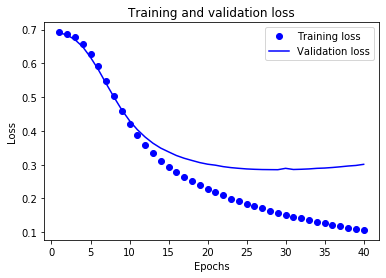

In [20]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

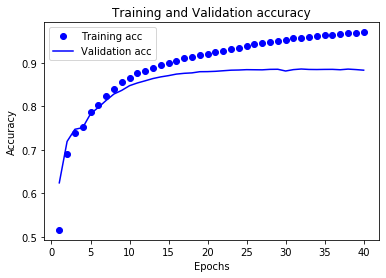

In [22]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()